In [1]:
import RunFullMap
import numpy as np
import scipy.linalg
import keras.backend as K
import tensorflow as tf
import sklearn.manifold
import sklearn.metrics

import Diffusion as df
import os.path
from autoencoder import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.utils import np_utils
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers

from polynomialcurve import PolynomialPointCurve
import LaplacianEigenmaps




Using TensorFlow backend.


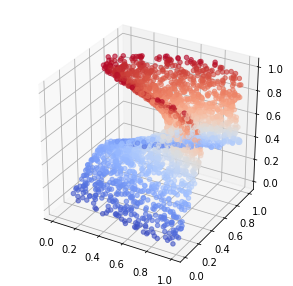

In [2]:
polycurve = PolynomialPointCurve(seed=3141, dimension=3, avg_dims_per_term=1, avg_power_per_dim=2, num_terms=3, avg_mono_term_power=1, max_coeff=2)
#3141 is a good seed
polycurve.compute_threshold(.05)
data = polycurve.gen_noisy_points(3000)
fig=plt.figure(figsize=(5,5))
a1=fig.add_subplot(111, projection='3d')
a1.scatter(data[:,0], data[:,1], data[:,2], c = data[:,2], cmap='coolwarm', alpha=.6)
plt.show()

In [3]:
data = polycurve.gen_noisy_points(3000)

In [4]:
T_THRESH = 2000
train = data[:T_THRESH]
test = data[T_THRESH:]

In [5]:
def noisy_average_predict(pred_net, data, num_samples=400, dimensional_perturbation_size = .002):
    data = data[:,np.newaxis,:]
    data = np.repeat(data, num_samples, axis=1)
    data += np.random.uniform(-dimensional_perturbation_size, dimensional_perturbation_size, data.shape)
    flat_data = np.reshape(data, (data.shape[0]*data.shape[1], data.shape[2]))
    predictions = np.reshape(pred_net.predict(flat_data), data.shape)
    return (np.average(predictions, axis=1))

def graph_train_test(pred_net, train, test, average_predict=False):
    fig = plt.figure(figsize=(10,5))
    if not average_predict:
        train_pred = pred_net.predict(train)
        test_pred = pred_net.predict(test)
    else:
        train_pred = noisy_average_predict(pred_net, train)
        test_pred = noisy_average_predict(pred_net, test)
    a1 = fig.add_subplot(121, projection='3d')
    #a1.scatter(train[:,0], train[:,1],train[:,2], color='blue')
    a1.scatter(train_pred[:,0], train_pred[:,1],train_pred[:,2], c = train_pred[:,2], cmap='coolwarm', alpha=.6)
    a1.set_title('Train data')
    a2 = fig.add_subplot(122, projection='3d')
    #a2.scatter(test[:,0], test[:,1], test[:,2], color='blue')
    a2.scatter(test_pred[:,0], test_pred[:,1], test_pred[:,2], c = test_pred[:,2], cmap='coolwarm', alpha=.6)
    a2.set_title('Test data')
    print ("Train: Original error " + str(polycurve.compute_error(train, orig_points = train, error_type = 'evaluative')) 
       + "\nTrain evaluative error " + str(polycurve.compute_error(train_pred, orig_points = train, error_type = 'evaluative'))
       + "\nTrain positional error " + str(polycurve.compute_error(train_pred, orig_points = train, error_type = 'positional')))
    print ("Test: Original error " + str(polycurve.compute_error(test, orig_points = test, error_type = 'evaluative')) 
       + "\nTrain evaluative error " + str(polycurve.compute_error(test_pred, orig_points = test, error_type = 'evaluative'))
       + "\nTrain positional error " + str(polycurve.compute_error(test_pred, orig_points = test, error_type = 'positional')))    

In [6]:
norm_net = RunFullMap.DiffusionNet(train, 2, embedding='lw', visual=False)

Gpu available:  True


W0417 14:25:46.278149 140532668933952 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0417 14:25:46.278777 140532668933952 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0417 14:25:46.280182 140532668933952 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0417 14:25:46.291065 140532668933952 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.

W0417 14:25:46.3

Using power-weights
Done embedding
Done encoder
Done decoder


W0417 14:26:19.806494 140532668933952 deprecation_wrapper.py:119] From /home/stephen/Desktop/diffusion_net/RunFullMap.py:179: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



Original method:
Train: Original error 0.39005152573843926
Train evaluative error 0.09048712053472072
Train positional error 0.0428986565993779
Test: Original error 0.4004110452931094
Train evaluative error 0.0967193990100768
Train positional error 0.04614280907017111


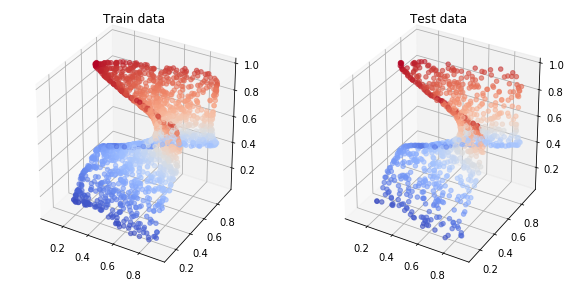

In [7]:
print("Original method:")
graph_train_test(norm_net, train, test)

In [8]:
print("Original, with averaging:")
graph_train_test(norm_net, train, test, average_predict=True)

Original, with averaging:


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[800000,40] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MatMul (defined at /home/stephen/Desktop/diffusion_net/RunFullMap.py:148) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[800000,40] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MatMul (defined at /home/stephen/Desktop/diffusion_net/RunFullMap.py:148) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[MatMul_2/_15]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node MatMul:
 Placeholder (defined at /home/stephen/Desktop/diffusion_net/RunFullMap.py:158)	
 Variable_1/read (defined at /home/stephen/Desktop/diffusion_net/RunFullMap.py:124)

Input Source operations connected to node MatMul:
 Placeholder (defined at /home/stephen/Desktop/diffusion_net/RunFullMap.py:158)	
 Variable_1/read (defined at /home/stephen/Desktop/diffusion_net/RunFullMap.py:124)

Original stack trace for 'MatMul':
  File "/home/stephen/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/stephen/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/stephen/anaconda3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/home/stephen/anaconda3/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/home/stephen/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 708, in __init__
    self.run()
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-8bea0c3181e2>", line 1, in <module>
    norm_net = RunFullMap.DiffusionNet(train, 2, embedding='lw', visual=False)
  File "/home/stephen/Desktop/diffusion_net/RunFullMap.py", line 159, in __init__
    Z = encoder(X)
  File "/home/stephen/Desktop/diffusion_net/RunFullMap.py", line 148, in encoder
    h1 = tf.nn.sigmoid(tf.matmul(x, E_W1) + E_b1)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py", line 2647, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 5925, in mat_mul
    name=name)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/stephen/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


<Figure size 720x360 with 0 Axes>

In [ ]:
lap_net = RunFullMap.DiffusionNet(train, 2, embedding='laplacian', visual=False)

In [ ]:
print("Laplacian method:")
graph_train_test(lap_net, train, test)